# Text Classification AI Workshop
by [Saiph Savage](http://saiph.org) and [Carlos Toxtli](https://www.carlostoxtli.com/#textwork)

Adapted from the [Ahmed Besbes](https://ahmedbesbes.com/) [article](https://ahmedbesbes.com/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification.html)

# 0 - Data Collection

Lets find some sources of online reviews

https://www.sitejabber.com

https://www.consumeraffairs.com/


## Setup

In [ ]:
%%time
site = 'sitejabber'
ratings = ['1', '2', '3', '4', '5']
companies = ['mturk.com']

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


## Code

In [ ]:
%%time
from bs4 import BeautifulSoup
import requests
import argparse
import random
import pandas
import time

min_time = 0
max_time = 1
selectors_row = {}
selectors_row['sitejabber'] = {}
selectors_row['sitejabber']['title'] = {'sel':'.review_title'}
selectors_row['sitejabber']['content'] = {'sel':'.review_content'}
selectors_row['consumeraffairs'] = {}
selectors_row['consumeraffairs']['title'] = {'sel':'.rvw-aut__inf strong:nth-of-type(1)'}
selectors_row['consumeraffairs']['content'] = {'sel':'.rvw-bd p:nth-of-type(2)'}

def get_values(obj, selectors):
	output = {}
	for key in selectors.keys():
		obj_sel = obj.select(selectors[key]['sel'])
		if len(obj_sel) > 0:
			output[key] = obj_sel[0].text
			if 'type' in selectors[key]:
				output[key] = selectors[key]['type'](output[key])
	return output

def extract_consumeraffairs(company,ratings):
	reviews = []
	for rating in ratings:
		page = 1
		last_html = ''
		while True:
			print('Extracting company: %s Rating: %s Page: %s'%(company,rating,page))
			url = 'https://www.consumeraffairs.com/%s.html?page=%s#sort=recent&filter=%s' % (company, page, rating)
			r = requests.get(url)
			if len(r.history) > 0:
				if r.history[0].status_code == 302:
					break
			html_doc = r.text
			last_html = html_doc
			soup = BeautifulSoup(html_doc, 'html.parser')
			all_reviews = soup.select('.rvw')
			for one_review in all_reviews:
				review = get_values(one_review, selectors_row['consumeraffairs'])
				review['rating'] = rating
				reviews.append(review)
			page += 1
	return reviews

def extract_sitejabber(company,ratings):
	reviews = []
	for rating in ratings:
		page = 1
		while True:
			print('Extracting company: %s Rating: %s Page: %s'%(company,rating,page))
			time.sleep(random.randint(min_time, max_time))
			url = 'https://www.sitejabber.com/reviews/%s?page=%s&rating=%s#reviews' % (company, page, rating)
			r = requests.get(url)
			html_doc = r.text
			soup = BeautifulSoup(html_doc, 'html.parser')
			all_reviews = soup.select('.review_row')
			if len(all_reviews) == 0:
				break
			else:
				page += 1
				for one_review in all_reviews:
					review = get_values(one_review, selectors_row['sitejabber'])
					review['rating'] = rating
					reviews.append(review)
	return reviews

CPU times: user 15 µs, sys: 5 µs, total: 20 µs
Wall time: 23.1 µs


## Run the code

In [ ]:
%%time
if site == 'sitejabber':
  for company in companies:
    reviews	= extract_sitejabber(company,ratings)
    df = pandas.DataFrame(reviews)
    filename = '%s_%s.csv'%(company,site)
    df.to_csv(filename)
elif site == 'consumeraffairs':
  for company in companies:
    reviews	= extract_consumeraffairs(company,ratings)
    df = pandas.DataFrame(reviews)
    company = company.replace('/','_')
    filename = '%s_%s.csv'%(company,site)
    df.to_csv(filename)

Extracting company: mturk.com Rating: 1 Page: 1
Extracting company: mturk.com Rating: 1 Page: 2
Extracting company: mturk.com Rating: 2 Page: 1
Extracting company: mturk.com Rating: 2 Page: 2
Extracting company: mturk.com Rating: 3 Page: 1
Extracting company: mturk.com Rating: 3 Page: 2
Extracting company: mturk.com Rating: 4 Page: 1
Extracting company: mturk.com Rating: 4 Page: 2
Extracting company: mturk.com Rating: 5 Page: 1
Extracting company: mturk.com Rating: 5 Page: 2
CPU times: user 678 ms, sys: 36.6 ms, total: 714 ms
Wall time: 8.59 s


## Download the results

In [ ]:
from google.colab import files

try:
  files.download(filename)
except:
  print("Try again")

## Data labeling

This directory contains data already coded by crowd workers

https://drive.google.com/drive/folders/1cvtT8x3Ndhpj0cXFfWRrREM5Q-iNedC6?usp=sharing


## Load the labeled data

### Load train file

In [ ]:
%%time
!mkdir data
import shutil
from google.colab import files

models = {}
test_file = False
uoload_file = True
drive_file_id = '1bNykOqmzvoaIZdqrM39-xcESVIMcxOHH'
print('Provide train data')

def download_train_file():
  !pip install gdown
  import gdown
  gdown.download('https://drive.google.com/uc?id=' + drive_file_id, './data/train.csv', False)

if uoload_file:
  try:
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
      shutil.copy(fn,'./data/train.csv')
  except:
    download_train_file()
else:
  download_train_file()

Provide train data


Saving train_uber_online (1).csv to train_uber_online (1).csv
User uploaded file "train_uber_online (1).csv" with length 153456 bytes
CPU times: user 62.8 ms, sys: 13.2 ms, total: 75.9 ms
Wall time: 7.08 s


### Load test file (OPTIONAL, it can automatically generate it from the train file)

In [ ]:
print('Provide test data')
try:
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.copy(fn,'./data/test.csv')
    test_file = True
except:
  pass

Provide test data


# 1 - Data pre processing

This article is an extension of a <a href="https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html" style="text-decoration: none">previous one</a> I wrote when I was experimenting sentiment analysis on twitter data. Back in the time, I explored a simple model: a two-layer feed-forward neural network trained on **keras**. The input tweets were represented as document vectors resulting from a weighted average of the embeddings of the words composing the tweet.

The embedding I used was a word2vec model I trained from scratch on the corpus using **gensim**. The task was a binary classification and I was able with this setting to achieve 79% accuracy.

The goal of this post is to explore other NLP models trained on the same dataset and then benchmark their respective performance on a given test set.

We'll go through different models: from simple ones relying on a bag-of-word representation to a heavy machinery deploying convolutional/recurrent networks: We'll see if we'll score more than 79% accuracy! 

<img src="https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/rnn_unrolled.png?raw=1" width="100%">

I will start from simple models and add up complexity progressively. The goal is also to show that ** simple models work well too**.

So I'm going to try out these:

- Logistic regression with word ngrams
- Logistic regression with  character ngrams
- Logistic regression with word and character ngrams
- Recurrent neural network (bidirectional GRU) without pre-trained embeddings
- Recurrent neural network (bidirectional GRU) with GloVe pre-trained embeddings
- Multi channel Convolutional Neural Network 
- RNN (Bidirectional GRU) + CNN model 

By the end of this post, you will have a boilerplate code for each of these NLP techniques. It'll help you kickstart your NLP project and eventually achieve state-of-the art results (some of these models are really powerful).

We'll also provide a comprehensive benchmark from which we'll tell which model is best suited for predicting the sentiment of a tweet.

In the related git repo, I will publish the different models, their predictions, as well as the test set. You can try them yourself and get confident about the results

Let's get started!

Create directories structure

In [ ]:
!mkdir predictions
!mkdir models
!mkdir -p models/rnn_no_embeddings
!mkdir -p models/rnn_with_embeddings
!mkdir -p models/cnn_multi_channel
!mkdir -p models/rnn_cnn
!mkdir images
!mkdir embeddings

Downloading word vectors (GloVe)

In [ ]:
%%time
import zipfile
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
zip_file = zipfile.ZipFile('glove.840B.300d.zip')
zip_file.extractall('./embeddings/')

--2019-08-28 12:08:43--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-08-28 12:08:43--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2019-08-28 12:08:43--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

Import NLP corpus from NLTK

In [ ]:
%%time
import os
import re
import string

import warnings
warnings.simplefilter("ignore", UserWarning)
from matplotlib import pyplot as plt
%matplotlib inline


import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np 
from string import punctuation

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from sklearn.externals import joblib

import scipy
from scipy.sparse import hstack

from tqdm import tqdm
from tqdm import tqdm_notebook
tqdm.pandas(desc="progress-bar")

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
CPU times: user 1.09 s, sys: 206 ms, total: 1.3 s
Wall time: 2.15 s


Load Word Vectors to memory

In [ ]:
%%time
def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None
    
embeddings_index = dict(get_coefs(*o.strip().split()) for o in tqdm_notebook(open('./embeddings/glove.840B.300d.txt')))

embed_size=300

for k in tqdm_notebook(list(embeddings_index.keys())):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size, ):
            embeddings_index.pop(k)
    except:
        pass

if None in embeddings_index:
  embeddings_index.pop(None)
  
values = list(embeddings_index.values())
all_embs = np.stack(values)

emb_mean, emb_std = all_embs.mean(), all_embs.std()


CPU times: user 3min 3s, sys: 14.5 s, total: 3min 17s
Wall time: 3min 6s


The dataset can be downloaded from this <a href="http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/">link</a>.

We'll load it and restrict ourselves to the variables we need (Sentiment and SentimentText).

It contains 1578614 classified tweets, each row is marked as 1 for positive sentiment and 0 for negative sentiment.

The author recommend using 1/10 for testing the algorithm and the rest for training.

Load train and test CSV files to memory

In [ ]:
%%time
data = pd.read_csv('./data/train.csv', encoding='latin1', usecols=['text', 'label'])
data.columns = ['text', 'label']
if test_file:
  data_test = pd.read_csv('./data/test.csv', encoding='latin1', usecols=['text', 'label'])
  data_test.columns = ['text', 'label']
data = data.sample(frac=1, random_state=42)
print(data.shape)

(328, 2)
CPU times: user 11 ms, sys: 1.03 ms, total: 12 ms
Wall time: 19.8 ms


Show the files content

In [ ]:
%%time
for row in data.head(10).iterrows():
    print(row[1]['label'], row[1]['text']) 

0 $579 for an SUV to take us 20 minutes down the road. Find alternate transportation! Not to mention their customer service is the worst customer service I have seen in a "customer service based" company! WHAT A JOKE!
1 If you are in the Philadelphia area and your uber driver is Daemon, cancel it real quick. When she picked me up she was at the wrong address so I had to literally walk a 1/2 block to her car and when she called me to ask where I was at, she was rude, even though she was at the wrong house! Her car smelled very bad (musty and dirty clothes) and it was dirty! She had water bottles on the floor and crumbs on her seats. I couldn't even dust them off because of the kind of seats she had. So I sat in crumbs the entire ride to work. When it was time to drop me off, she was at the wrong location once again and I had to get out and walk a block to my building. She is by far the worst uber driver and I have had some bad drivers but she is flat out terrible.
0 I will never underst

Tweets are noisy, let's clean them by removing urls, hashtags and user mentions.

Tokenize function definition

In [ ]:
%%time
def tokenize(tweet):
    lemmatizer = WordNetLemmatizer()
    stop = stopwords.words('english') + list(string.punctuation)
    #print('WORD', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r"#(\w+)", '', tweet)
    tweet = re.sub(r"@(\w+)", '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.strip().lower()
    tokens = word_tokenize(tweet)
    #tokens = [i for i in word_tokenize(tweet) if i not in stop]
    #tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs





Once the data is clean, we save it on disk.

In [ ]:
%%time
data['tokens'] = data.text.progress_map(tokenize)
data['cleaned_text'] = data['tokens'].map(lambda tokens: ' '.join(tokens))
data[['label', 'cleaned_text']].to_csv('./data/cleaned_text.csv')
data = pd.read_csv('./data/cleaned_text.csv')

if test_file:
  data_test['tokens'] = data_test.text.progress_map(tokenize)

  data_test['cleaned_text'] = data_test['tokens'].map(lambda tokens: ' '.join(tokens))
  data_test[['label', 'cleaned_text']].to_csv('./data/cleaned_text_test.csv')
  data_test = pd.read_csv('./data/cleaned_text_test.csv')

print(data.shape)

progress-bar: 100%|██████████| 328/328 [00:00<00:00, 1551.02it/s]

(328, 3)
CPU times: user 222 ms, sys: 10.8 ms, total: 233 ms
Wall time: 231 ms


In [ ]:
%%time
data.head()

CPU times: user 330 µs, sys: 1.07 ms, total: 1.39 ms
Wall time: 1.02 ms


,Unnamed: 0,label,cleaned_text
0,231,0,579 for an suv to take us 20 minutes down the ...
1,110,1,if you are in the philadelphia area and your u...
2,250,0,i will never understand why the drivers of the...
3,9,1,drivers are allowed to cancel for no reason an...
4,93,1,so i used uber last night never use it i got d...


Now that the dataset is cleaned, let's prepare a train/test split to build our models. 

We'll use this split throughout all the notebook.

In [ ]:
%%time
if test_file:
  x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'], 
                                                    data['label'], 
                                                    test_size=2/data.shape[0], 
                                                    random_state=42,
                                                    stratify=data['label'])
  x_test, y_test = data_test['cleaned_text'], data_test['label']
else:
  x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'], 
                                                      data['label'], 
                                                      test_size=0.1, 
                                                      random_state=42,
                                                      stratify=data['label'])

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(295,) (33,) (295,) (33,)
CPU times: user 53.7 ms, sys: 0 ns, total: 53.7 ms
Wall time: 52.8 ms


I'm saving the test labels on disk for later use.

In [ ]:
%%time
pd.DataFrame(y_test).to_csv('./predictions/y_true.csv', index=False, encoding='utf-8')

CPU times: user 1.56 ms, sys: 986 µs, total: 2.54 ms
Wall time: 2.04 ms


Let's start applying some machine learning now:

# 2 - Bag of word model based on word ngrams

So. What's an **n-gram** ?

 ![](https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/ngrams.png?raw=1)

As we see it in this figure, n-grams are simply all combinations of adjacent words (in this case) of length n that you can find in your source text. 

In our model, we are going to use unigrams (n=1) and bigrams (n=2) as features. 

The dataset will therefore be represented as a matrix where each row refers to a tweet and each column refers to a feature (unigram or bigram) extracted from the text (after tokenization and cleaning). Each cell will be the **tf-idf** score. (we could also use a simple count but tf-idf is more used in general and usually works better). We call this matrix the **document-term matrix**. 

As you can imagine, the number of unique unigrams and bigrams of 1.5 million-tweet corpus is huge. In practice, we will set this number to a fixed value, for a computational reason. You can determine this value by using a cross-validation.

This is what the corpus should look like after vectorization.

![](https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/tfidf.jpg?raw=1)

I like pizza a lot
===
    
Let's say we want to feed this sentence to a predictive model using the features described above.

Given that we're using unigrams and bigrams, the model will extract the following features:

i, like, pizza, a, lot, i like, like pizza, pizza a, a lot
===

Therefore, the sentence will be formed by a vector of size N (= total number of tokens) containing lots of zeros and the tf-idf scores of these ngrams.
So you can clearly see that we will be dealing with large and **sparse** vectors.

When dealing with large and sparse data, linear models generally perform quite well. Besides, they are faster to train than other types of models (e.g. tree-based models).

I can tell from past experience that **logistic regression** works well on top of sparse tfidf matrices.

In [ ]:
%%time
vectorizer_word = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 2))

vectorizer_word.fit(x_train)

tfidf_matrix_word_train = vectorizer_word.transform(x_train)
tfidf_matrix_word_test = vectorizer_word.transform(x_test)

CPU times: user 80.8 ms, sys: 763 µs, total: 81.6 ms
Wall time: 103 ms


After generating  tfidf matrices for both train and test sets, we can build our first model an test it.

The tifidf matrices are the features of the logistic regression.

In [ ]:
%%time
lr_word = LogisticRegression(solver='sag', verbose=2)
lr_word.fit(tfidf_matrix_word_train, y_train)

convergence after 20 epochs took 0 seconds
CPU times: user 4.96 ms, sys: 76 µs, total: 5.04 ms
Wall time: 4.69 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Once the model is trained, we apply it on the test data to get predictions. Then we save these values as well as the model on disk.

In [ ]:
%%time
joblib.dump(lr_word, './models/lr_word_ngram.pkl')
models['lr_word'] = {"model": lr_word, "process": vectorizer_word.transform}
y_pred_word = lr_word.predict(tfidf_matrix_word_test)
pd.DataFrame(y_pred_word, columns=['y_pred']).to_csv('./predictions/lr_word_ngram.csv', index=False)

CPU times: user 3.7 ms, sys: 948 µs, total: 4.65 ms
Wall time: 3.98 ms


Let's see what accuracy score we have:

In [ ]:
%%time
y_pred_word = pd.read_csv('./predictions/lr_word_ngram.csv')
print(accuracy_score(y_test, y_pred_word))
print(roc_auc_score(y_test, y_pred_word))

0.7272727272727273
0.7279411764705881
CPU times: user 5.84 ms, sys: 993 µs, total: 6.83 ms
Wall time: 6.81 ms


**72.7% accuracy** for a first model ! Quite not bad. Let's move to the next model.

# 3 - Bag of word model based on character ngrams

We never said that ngrams were for words only. We can apply them at a character level as well.

<img src='https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/ngrams_char.jpg?raw=1' width="50%">
 

You see it coming, right? We're going to apply the same code above to character ngrams instead, and we will go up to 4-grams.

This basically means that a sentence like "I like this movie" will have these features:

I, l, i, k, e, ..., I li,  lik, like, ..., this, ... , is m, s mo, movi, ...
===

Character ngrams are surprisingly very effective. They can even outperform word tokens in modeling a language task. For example <a href="http://www.icsd.aegean.gr/lecturers/stamatatos/papers/ijait-spam.pdf">spam filters</a> or <a href="http://www.martijnwieling.nl/files/groningen_power.pdf">Native Language Identification</a> heavily rely on character ngrams.

Unlike the previous model which learns combinations of words, this model learns combinations of letters, which can handle the morphological makeup of a word.

One of the advantages of the character-based representation is the better handling of **misspelled words**.

Let's run the same pipeline :

In [ ]:
%%time
vectorizer_char = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='char', 
                             ngram_range=(1, 4))

vectorizer_char.fit(tqdm_notebook(x_train, leave=False));

tfidf_matrix_char_train = vectorizer_char.transform(x_train)
tfidf_matrix_char_test = vectorizer_char.transform(x_test)

lr_char = LogisticRegression(solver='sag', verbose=2)
lr_char.fit(tfidf_matrix_char_train, y_train)

models['lr_char'] = {"model": lr_char, "process": vectorizer_char.transform}
y_pred_char = lr_char.predict(tfidf_matrix_char_test)
joblib.dump(lr_char, './models/lr_char_ngram.pkl')

pd.DataFrame(y_pred_char, columns=['y_pred']).to_csv('./predictions/lr_char_ngram.csv', index=False)

convergence after 29 epochs took 0 seconds
CPU times: user 649 ms, sys: 2.1 ms, total: 651 ms
Wall time: 650 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [ ]:
%%time
y_pred_char = pd.read_csv('./predictions/lr_char_ngram.csv')
print(accuracy_score(y_test, y_pred_char))
print(roc_auc_score(y_test, y_pred_char))

0.8484848484848485
0.8455882352941176
CPU times: user 5.3 ms, sys: 958 µs, total: 6.26 ms
Wall time: 6.39 ms


** 84.8% accuracy ! ** Character-ngrams perfom better that word-ngrams.

# 4 - Bag of word model based on word and character ngrams

Character ngram features seem to provide a better accuracy than word ngrams. But what about the combination of the two: word + character ngrams?

Let's concatenate the two tfidf matrices we generated and build a new, *hybrid* tfidf matrix.

This model will help us learn the indentity of a word and its possible neighbors as well as its morphological structure.

These properties are combined.

In [ ]:
%%time
tfidf_matrix_word_char_train =  hstack((tfidf_matrix_word_train, tfidf_matrix_char_train))
tfidf_matrix_word_char_test =  hstack((tfidf_matrix_word_test, tfidf_matrix_char_test))

lr_word_char = LogisticRegression(solver='sag', verbose=2)
lr_word_char.fit(tfidf_matrix_word_char_train, y_train)

models['lr_word_char'] = {"model": lr_word_char, "process": lambda x: hstack((vectorizer_word.transform(x), vectorizer_char.transform(x)))}
y_pred_word_char = lr_word_char.predict(tfidf_matrix_word_char_test)
joblib.dump(lr_word_char, './models/lr_word_char_ngram.pkl')

pd.DataFrame(y_pred_word_char, columns=['y_pred']).to_csv('./predictions/lr_word_char_ngram.csv', index=False)

convergence after 52 epochs took 0 seconds
CPU times: user 105 ms, sys: 684 µs, total: 105 ms
Wall time: 105 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [ ]:
%%time
y_pred_word_char = pd.read_csv('./predictions/lr_word_char_ngram.csv')
print(accuracy_score(y_test, y_pred_word_char))
print(roc_auc_score(y_test, y_pred_word_char))

0.696969696969697
0.6966911764705882
CPU times: user 5.91 ms, sys: 3.07 ms, total: 8.98 ms
Wall time: 7.04 ms


Awesome: **69.6% accuracy**. We just increased by one whole unit and outperformed the two previous settings.

## What can we say about bag-of-word models before we move on?


- **Pros**: They can be surprisingly powerful given their simplicity, they are fast to train, and easy to understand.  
- **Cons**: Even though ngrams bring some context between words, bag of word models fail in modeling long-term dependencies between words in a sequence.


Now we're going to dive into deep learning models. The reason deep learning outperform bag of word models is the ability to capture the sequencial dependency between words in a sentence. This has been possible thanks to the invention of special neural network architectures called **Recurrent Neural Networks**.

I won't cover the theoretical foundations of RNNs, but here's a <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">link</a> I find worth reading. It's from Cristopher Olah's blog. It details LSTM: Long Short Term Memory. A special kind of RNN. 

Before starting, we have to setup a deep learning dedicated environment that uses Keras on top of Tensorflow. I honestly tried to run everything on my personal laptop but given the important size of the dataset and the complexity of RNN architectures, this has not been practical. At all.

One good option is AWS. I generally use this <a href="https://aws.amazon.com/marketplace/pp/B077GCH38C?qid=1527197041958&sr=0-1&ref_=srh_res_product_title">deep learning AMI</a> on an EC2 <a href="https://aws.amazon.com/ec2/instance-types/p2/">p2.xlarge</a> instance. Amazon AMI are pre-configured VM images, where all the packages (Tensorflow, PyTocrh, Keras, etc. ) are installed. I highly recommend this one which I have been using for a while.

In [ ]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


CPU times: user 1.28 s, sys: 156 ms, total: 1.44 s
Wall time: 1.84 s


# 5 - Recurrent Neural Network without pre-trained embedding

RNNs may look scary. Although they're complex to understand, they're quite interesting. They encapsulate a very beautiful design that overcomes traditional neural networks' shortcomings that rise when dealing with sequence data: text, time series, videos, DNA sequences, etc.

An RNN is a sequence of neural network blocks that are linked to each others like a chain. Each one is passing a message to a successor.

Again if you want to dive into the internal mechanics, I highly recommend Colah's <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">blog</a> out of which the diagram below is taken.

<img src="https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/rnn_unrolled.png?raw=1" width="100%">

![alt text](https://miro.medium.com/max/3032/1*yBXV9o5q7L_CvY7quJt3WQ.png)

We will process text data, which is a sequence type. The order of words is very important to the meaning. Hopefully RNNs take care of this and can capture long-term dependencies.

To use Keras on text data, we firt have to preprocess it. For this, we can use Keras' Tokenizer class. This object takes as argument **num_words** which is the maximum number of words kept after tokenization based on their word frequency.

In [ ]:
%%time
MAX_NB_WORDS = 80000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(data['cleaned_text'])

CPU times: user 32.6 ms, sys: 1.83 ms, total: 34.5 ms
Wall time: 34.5 ms


Once the tokenizer is fitted on the data, we can use it to convert text strings to sequences of numbers.

These numbers represent the position of each word in the dictionary (think of it as mapping). 

Let's see an example:

In [ ]:
%%time
x_train[15]

CPU times: user 681 µs, sys: 0 ns, total: 681 µs
Wall time: 819 µs


'my wallet was stolen out of an uber last night with my social security card inside and this was the message i sent over 4 hours ago and have yet to recieve a response i seriously question the legitimacy of this company and strongly advise people not to use the app i have been a big fan for almost two years but i truly believe there is an underlying issue with this company any other customer support system would be much more attentive to the matter and have consideration to help their customers with their best interest in mind to uber customer support i received an unusual phone call from your company this afternoon that made me so uncomfortable that i had to hang up the man on the phone had a hard time speaking clear english and said that he had contacted the driver but failed to answer any questions pertaining to the wallet even when asked directly the phone call seemed like it was coming from over seas unless it was a mock phone call it has made me begin to question the legitimacy o

Here's how the tokenizer turns it into a sequence of digits. 

In [ ]:
%%time
tokenizer.texts_to_sequences([x_train[15]])

CPU times: user 0 ns, sys: 326 µs, total: 326 µs
Wall time: 331 µs


[[8,
  713,
  7,
  1148,
  69,
  11,
  33,
  6,
  146,
  203,
  24,
  8,
  888,
  889,
  143,
  1132,
  4,
  22,
  7,
  1,
  465,
  2,
  250,
  118,
  225,
  273,
  364,
  4,
  20,
  610,
  3,
  1149,
  5,
  341,
  2,
  611,
  529,
  1,
  1150,
  11,
  22,
  73,
  4,
  1151,
  1152,
  130,
  17,
  3,
  48,
  1,
  79,
  2,
  20,
  89,
  5,
  228,
  714,
  9,
  366,
  229,
  335,
  25,
  2,
  1711,
  612,
  55,
  15,
  33,
  1712,
  216,
  24,
  22,
  73,
  150,
  147,
  65,
  209,
  430,
  62,
  37,
  156,
  112,
  1713,
  3,
  1,
  466,
  4,
  20,
  1153,
  3,
  170,
  45,
  168,
  24,
  45,
  367,
  1714,
  10,
  530,
  3,
  6,
  65,
  209,
  2,
  342,
  33,
  1715,
  90,
  95,
  31,
  52,
  73,
  22,
  1716,
  18,
  194,
  14,
  36,
  1154,
  18,
  2,
  34,
  3,
  1155,
  29,
  1,
  467,
  21,
  1,
  90,
  34,
  5,
  431,
  44,
  613,
  614,
  294,
  4,
  53,
  18,
  12,
  34,
  226,
  1,
  13,
  25,
  715,
  3,
  368,
  150,
  890,
  1717,
  3,
  1,
  713,
  68,
  46,
  132,
  891,


Let's now apply this tokenizer on the train and test sequences:

In [ ]:
%%time
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

CPU times: user 18.6 ms, sys: 0 ns, total: 18.6 ms
Wall time: 18.5 ms


Now the tweets are mapped to lists of integers. However, we still cannot stack them together in a matrix since they have different lengths.
Hopefully Keras allows to **pad** sequences with **0s** to a maximum length. We'll set this length to 35. (which is the maximum numbers of tokens in the tweets).

In [ ]:
%%time
MAX_LENGTH = 35
padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH)

CPU times: user 4.56 ms, sys: 7.2 ms, total: 11.8 ms
Wall time: 8.12 ms


In [ ]:
%%time
padded_train_sequences

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


array([[  22,   41,   45, ..., 3284, 3285, 3286],
       [   6,  772,   88, ...,  139,   54,  631],
       [   0,    0,    0, ...,    5,  410,  402],
       ...,
       [   6,  332,   15, ..., 1660,    3,  187],
       [1394, 2302, 1395, ..., 2319, 1394, 2320],
       [  23,   10,   24, ...,   48,   22,   41]], dtype=int32)

In [ ]:
%%time
padded_train_sequences.shape

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


(295, 35)

Now the data is ready to be fed to an RNN.

Here are some elements of the architecture I'll be using:

- An embedding dimension of 300. This means that each word from the 80000 that we'll be using is mapped to a 300-dimension dense vector (of float numbers). The mapping will adjust throughout the training.

- A spatial dropout is applied on the embedding layer to reduce overfitting: it basically looks at batches of 35x300 matrices and randomly drop (set to 0) word vectors (i.e rows) in each matrix. This helps not to focus on specific words in an attempt to generalize well.

- A bidirectional Gated Recurrent Unit (GRU): this is the recurrent network part. It's a faster variant of the LSTM architecture. Think of it as a combination of two recurrent networks that scan the text sequence in both directions: from left to right and from right to left. This allows the network, when reading a given word, to understand it by using the context from both past and future information. The GRU takes as parameter a number of units which is the dimension of the output h_t of each network block. We will set this number to 100. And since we are using a bidirectional version of the GRU, the final output per RNN block will be of dimension 200.
 
The output of the bidirectional GRU has the dimension (batch_size, timesteps, units). This means that if we use a typical batch size of 256, this dimension will be (256, 35, 200)

- On top of every batch, we apply a global average pooling that consists in averaging the output vectors corresponding to the each time step (i.e the words)

- We apply the same operation with max pooling. 

- We concatenate the outputs of the two previous operations.

In [ ]:
%%time
def get_simple_rnn_model():
    embedding_dim = 300
    embedding_matrix = np.random.random((MAX_NB_WORDS, embedding_dim))
    
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(input_dim=MAX_NB_WORDS, output_dim=embedding_dim, input_length=MAX_LENGTH, 
                  weights=[embedding_matrix], trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

rnn_simple_model = get_simple_rnn_model()

W0828 12:32:45.315006 140690224174976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 12:32:45.353599 140690224174976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 12:32:45.360343 140690224174976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 12:32:45.370623 140690224174976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 12:32:45.371589 1406902241

CPU times: user 1.28 s, sys: 829 ms, total: 2.11 s
Wall time: 4.5 s


Let's look at the different layers of this model:

In [ ]:
%%time
plot_model(rnn_simple_model, 
           to_file='./images/rnn_simple_model.png', 
           show_shapes=True, 
           show_layer_names=True)

CPU times: user 2.02 ms, sys: 173 ms, total: 175 ms
Wall time: 650 ms


<img src="https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/rnn_simple_model.png?raw=1" width="100%">

During the training, model checkpoint is used. It allows to automatically save (on disk) the best models (w.r.t accuracy measure) at the end of each epoch.

In [ ]:
%%time
filepath="./models/rnn_no_embeddings/weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 32
epochs = 20

history = rnn_simple_model.fit(x=padded_train_sequences, 
                    y=y_train, 
                    validation_data=(padded_test_sequences, y_test), 
                    batch_size=batch_size, 
                    callbacks=[checkpoint], 
                    epochs=epochs, 
                    verbose=1)

best_rnn_simple_model = load_model('./models/rnn_no_embeddings/weights-improvement.hdf5')

models['best_rnn_simple_model'] = {"model": best_rnn_simple_model, "process": lambda x: pad_sequences(tokenizer.texts_to_sequences(x), maxlen=MAX_LENGTH)}
y_pred_rnn_simple = best_rnn_simple_model.predict(padded_test_sequences, verbose=1, batch_size=2048)

y_pred_rnn_simple = pd.DataFrame(y_pred_rnn_simple, columns=['prediction'])
y_pred_rnn_simple['prediction'] = y_pred_rnn_simple['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
y_pred_rnn_simple.to_csv('./predictions/y_pred_rnn_simple.csv', index=False)

Train on 295 samples, validate on 33 samples
Epoch 1/20
295/295 [==============================] - 4s 12ms/step - loss: 0.7679 - acc: 0.4780 - val_loss: 0.6915 - val_acc: 0.4848

Epoch 00001: val_acc improved from -inf to 0.48485, saving model to ./models/rnn_no_embeddings/weights-improvement.hdf5
Epoch 2/20
295/295 [==============================] - 1s 5ms/step - loss: 0.6939 - acc: 0.5356 - val_loss: 0.6850 - val_acc: 0.5152

Epoch 00002: val_acc improved from 0.48485 to 0.51515, saving model to ./models/rnn_no_embeddings/weights-improvement.hdf5
Epoch 3/20
295/295 [==============================] - 1s 4ms/step - loss: 0.6868 - acc: 0.5525 - val_loss: 0.6709 - val_acc: 0.6667

Epoch 00003: val_acc improved from 0.51515 to 0.66667, saving model to ./models/rnn_no_embeddings/weights-improvement.hdf5
Epoch 4/20
295/295 [==============================] - 1s 4ms/step - loss: 0.6702 - acc: 0.5932 - val_loss: 0.6655 - val_acc: 0.5758

Epoch 00004: val_acc did not improve from 0.66667
Epoch 

In [ ]:
y_pred_rnn_simple = pd.read_csv('./predictions/y_pred_rnn_simple.csv')
print(accuracy_score(y_test, y_pred_rnn_simple))
print(roc_auc_score(y_test, y_pred_rnn_simple))

0.7272727272727273
0.7242647058823529


** 72.7% accuracy ! ** Quite not bad ! We are now performing better than the previous bag-of-word models because we are taking into account the sequence nature of the text. 

Can we do better?

# 6 - Recurrent Neural Network with GloVe pre-trained embeddings

In the last model, the embedding matrix was initialized randomly. What if we could use pre-trained word embeddings to intialize it instead?

Let's take an example: imagine that you have the word *pizza* in your corpus. Following the previous architecture, you would initialize it to a 300 dimension vector of random float values. This is perfectly fine. You can do that, and this embedding will adjust an evolve throughout training. However, what you could do instead of randomly picking a vector for pizza is using an embedding for this word that has been learnt from another model on a very large corpus. This is a special kind of **transfer learning**.

Using the knowledge from an external embedding can enhance the precision of your RNN because it integrates new information (lexical and semantic) about the words, an information that has been trained and distilled on a very large corpus of data. 

The pre-trained embedding we'll be using is <a href="https://nlp.stanford.edu/projects/glove/">GloVe</a>.

Official documentation: *GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.* 

The GloVe embeddings I'll be using are trained on a ** very large ** common internet crawl that includes:

- 840 Billion tokens, 
- 2.2 million size vocab

The zipped file is 2.03 GB download. Beware, this file cannot be easily loaded on a standard laptop.

The dimension of GloVe embeddings is 300. 

GloVe embeddings come in raw text data, where each line contains a word and 300 floats (the corresponding embedding). So the first thing to do is convert this structure to a python dictionary.

Once the embedding index in created, we extract all the vectors, we stack them together and compute their mean and standard deviation. 

Now we generate the embedding matrix. We will initialize it following a normal distribution of mean=emb_mean and std=emb_std.

Then we go through the 80000 words of our corpus. For each word, if it is contained in GloVe, we pick its embedding. 

Otherwise, we pass.

In [ ]:
%%time
word_index = tokenizer.word_index
nb_words = MAX_NB_WORDS
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

oov = 0
for word, i in tqdm_notebook(word_index.items()):
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oov += 1

print(oov)

def get_rnn_model_with_glove_embeddings():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

rnn_model_with_embeddings = get_rnn_model_with_glove_embeddings()

filepath="./models/rnn_with_embeddings/weights-improvement-glove.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 32
epochs = 20

history = rnn_model_with_embeddings.fit(x=padded_train_sequences, 
                    y=y_train, 
                    validation_data=(padded_test_sequences, y_test), 
                    batch_size=batch_size, 
                    callbacks=[checkpoint], 
                    epochs=epochs, 
                    verbose=1)

best_rnn_model_with_glove_embeddings = load_model('./models/rnn_with_embeddings/weights-improvement-glove.hdf5')

models['best_rnn_model_with_glove_embeddings'] = {"model": best_rnn_model_with_glove_embeddings, "process": lambda x: pad_sequences(tokenizer.texts_to_sequences(x), maxlen=MAX_LENGTH)}
y_pred_rnn_with_glove_embeddings = best_rnn_model_with_glove_embeddings.predict(
    padded_test_sequences, verbose=1, batch_size=2048)

y_pred_rnn_with_glove_embeddings = pd.DataFrame(y_pred_rnn_with_glove_embeddings, columns=['prediction'])
y_pred_rnn_with_glove_embeddings['prediction'] = y_pred_rnn_with_glove_embeddings['prediction'].map(lambda p: 
                                                                                                    1 if p >= 0.5 else 0)
y_pred_rnn_with_glove_embeddings.to_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv', index=False)


189
Train on 295 samples, validate on 33 samples
Epoch 1/20
295/295 [==============================] - 3s 11ms/step - loss: 0.6854 - acc: 0.5932 - val_loss: 0.6873 - val_acc: 0.5758

Epoch 00001: val_acc improved from -inf to 0.57576, saving model to ./models/rnn_with_embeddings/weights-improvement-glove.hdf5
Epoch 2/20
295/295 [==============================] - 1s 4ms/step - loss: 0.6373 - acc: 0.6407 - val_loss: 0.6740 - val_acc: 0.6364

Epoch 00002: val_acc improved from 0.57576 to 0.63636, saving model to ./models/rnn_with_embeddings/weights-improvement-glove.hdf5
Epoch 3/20
295/295 [==============================] - 1s 4ms/step - loss: 0.6122 - acc: 0.7017 - val_loss: 0.6475 - val_acc: 0.5758

Epoch 00003: val_acc did not improve from 0.63636
Epoch 4/20
295/295 [==============================] - 1s 4ms/step - loss: 0.5697 - acc: 0.7017 - val_loss: 0.6241 - val_acc: 0.6364

Epoch 00004: val_acc did not improve from 0.63636
Epoch 5/20
295/295 [==============================] - 1s 4

In [ ]:
%%time
y_pred_rnn_with_glove_embeddings = pd.read_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv')
print(accuracy_score(y_test, y_pred_rnn_with_glove_embeddings))
print(roc_auc_score(y_test, y_pred_rnn_with_glove_embeddings))

0.7272727272727273
0.7242647058823529
CPU times: user 8.06 ms, sys: 982 µs, total: 9.05 ms
Wall time: 9.97 ms


**72.7% accuracy ! ** Transfer learning from external word embeddings works! For the rest of the tutorial, I'll be using GloVe embeddings in the embedding matrix.

# 7 - Multi-channel Convolutional Neural Network

In this section, I'm experimenting a convolutional neural network architecture I read about <a href="http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/">here</a>. CNNs are generally used in computer vision. However, we've recently started applying them to NLP tasks and the results were promising. 

Let's briefly see what happens when we use convnets on text data. To explain this, I'm borrowing this famous diagram (below) from wildm.com (a very good blog!)

Let's consider the example it used: I like this movie very much ! (7 tokens)

- The embedding dimension of each word is 5. Therefore this sentence is represented by a matrix of dimension (7,5). You can think of it as an "image" (~ a matrix of digits/floats). 
- 6 Filters, 2 of size (2, 5) (3, 5) and (4, 5) are applied on this matrix. The particularity of these filters is that they are not square matrices and their width is equal to the embedding matrix's width. So the result of each convolution will be a column vector.

- Each column vector resulting from the convolution is subsampled using a maxpooling operation.

- The results of the maxpooling operations are concatenated in a final vector that is passed to a softmax function for classification.


What is the intuition behind ?
==

The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you're allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words).

Patterns could be expressions (word ngrams?) like "I hate", "very good" and therefore CNNs can identify them in the sentence regardless of their position.

<img src="https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/cnn_text.png?raw=1" width="75%">

In [ ]:
%%time
def get_cnn_model():
    embedding_dim = 300
    
    filter_sizes = [2, 3, 5]
    num_filters = 32
    drop = 0.3

    inputs = Input(shape=(MAX_LENGTH,), dtype='int32')
    embedding = Embedding(input_dim=MAX_NB_WORDS,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=MAX_LENGTH,
                                trainable=True)(inputs)

    reshape = Reshape((MAX_LENGTH, embedding_dim, 1))(embedding)
    conv_0 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[0], embedding_dim), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)

    conv_1 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[1], embedding_dim), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[2], embedding_dim), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_0)

    maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_1)

    maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_2)
    concatenated_tensor = Concatenate(axis=1)(
        [maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

cnn_model_multi_channel = get_cnn_model()

plot_model(cnn_model_multi_channel, 
           to_file='./images/cnn_model_multi_channel.png', 
           show_shapes=True, 
           show_layer_names=True)

W0828 12:41:09.558156 140690224174976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



CPU times: user 1.22 s, sys: 206 ms, total: 1.43 s
Wall time: 1.74 s


<img src="https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/cnn_model_multi_channel.png?raw=1" width="100%">

In [ ]:
%%time
filepath="./models/cnn_multi_channel/weights-improvement-cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 32
epochs = 20

history = cnn_model_multi_channel.fit(x=padded_train_sequences, 
                    y=y_train, 
                    validation_data=(padded_test_sequences, y_test), 
                    batch_size=batch_size, 
                    callbacks=[checkpoint], 
                    epochs=epochs, 
                    verbose=1)

best_cnn_model = load_model('./models/cnn_multi_channel/weights-improvement-cnn.hdf5')

models['best_cnn_model'] = {"model": best_cnn_model, "process": lambda x: pad_sequences(tokenizer.texts_to_sequences(x), maxlen=MAX_LENGTH)}
y_pred_cnn_multi_channel = best_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048)

y_pred_cnn_multi_channel = pd.DataFrame(y_pred_cnn_multi_channel, columns=['prediction'])
y_pred_cnn_multi_channel['prediction'] = y_pred_cnn_multi_channel['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
y_pred_cnn_multi_channel.to_csv('./predictions/y_pred_cnn_multi_channel.csv', index=False)

Train on 295 samples, validate on 33 samples
Epoch 1/20
295/295 [==============================] - 4s 14ms/step - loss: 0.9733 - acc: 0.5119 - val_loss: 0.8131 - val_acc: 0.5152

Epoch 00001: val_acc improved from -inf to 0.51515, saving model to ./models/cnn_multi_channel/weights-improvement-cnn.hdf5
Epoch 2/20
295/295 [==============================] - 0s 1ms/step - loss: 0.8568 - acc: 0.4847 - val_loss: 0.6866 - val_acc: 0.6061

Epoch 00002: val_acc improved from 0.51515 to 0.60606, saving model to ./models/cnn_multi_channel/weights-improvement-cnn.hdf5
Epoch 3/20
295/295 [==============================] - 0s 1ms/step - loss: 0.7536 - acc: 0.5424 - val_loss: 0.6438 - val_acc: 0.6364

Epoch 00003: val_acc improved from 0.60606 to 0.63636, saving model to ./models/cnn_multi_channel/weights-improvement-cnn.hdf5
Epoch 4/20
295/295 [==============================] - 0s 1ms/step - loss: 0.6991 - acc: 0.5797 - val_loss: 0.6336 - val_acc: 0.7273

Epoch 00004: val_acc improved from 0.63636 t

In [ ]:
%%time
y_pred_cnn_multi_channel = pd.read_csv('./predictions/y_pred_cnn_multi_channel.csv')
print(accuracy_score(y_test, y_pred_cnn_multi_channel))
print(roc_auc_score(y_test, y_pred_cnn_multi_channel))

0.7272727272727273
0.7261029411764706
CPU times: user 5.44 ms, sys: 4.19 ms, total: 9.63 ms
Wall time: 8.72 ms


** 72.7% accuracy **, we're less precise than RNNs but still better than BOW models. Maybe an investigation of the hyperparameters (number of filters, and size) gives an edge?

# 8 - Recurrent + Convolutional neural network

RNNs are powerful. Howerer, some people found out that they could maek them more robust by adding a convolutional layer on top of the reccurrent layer.

The rational behind is that RNNs allow you to embed the information about the sequence and previous words and CNN takes this embedding and extract local features from it. Having these two layers working together is a winning combination.

More about this <a href="http://konukoii.com/blog/2018/02/19/twitter-sentiment-analysis-using-combined-lstm-cnn-models/">here</a>.

In [ ]:
%%time
def get_rnn_cnn_model():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

rnn_cnn_model = get_rnn_cnn_model()

plot_model(rnn_cnn_model, to_file='./images/rnn_cnn_model.png', show_shapes=True, show_layer_names=True)

CPU times: user 1.87 s, sys: 665 ms, total: 2.53 s
Wall time: 2.24 s


<img src="https://github.com/ahmedbesbes/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification/blob/master/images/article_5/rnn_cnn_model.png?raw=1" width="100%">

In [ ]:
%%time
filepath="./models/rnn_cnn/weights-improvement-rnn-cnn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 32
epochs = 20

history = rnn_cnn_model.fit(x=padded_train_sequences, 
                    y=y_train, 
                    validation_data=(padded_test_sequences, y_test), 
                    batch_size=batch_size, 
                    callbacks=[checkpoint], 
                    epochs=epochs, 
                    verbose=1)

best_rnn_cnn_model = load_model('./models/rnn_cnn/weights-improvement-rnn-cnn.hdf5')

models['best_rnn_cnn_model'] = {"model": best_rnn_cnn_model, "process": lambda x: pad_sequences(tokenizer.texts_to_sequences(x), maxlen=MAX_LENGTH)}
y_pred_rnn_cnn = best_rnn_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048)

y_pred_rnn_cnn = pd.DataFrame(y_pred_rnn_cnn, columns=['prediction'])
y_pred_rnn_cnn['prediction'] = y_pred_rnn_cnn['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
y_pred_rnn_cnn.to_csv('./predictions/y_pred_rnn_cnn.csv', index=False)

Train on 295 samples, validate on 33 samples
Epoch 1/20
295/295 [==============================] - 4s 14ms/step - loss: 0.7259 - acc: 0.5661 - val_loss: 0.6743 - val_acc: 0.5455

Epoch 00001: val_acc improved from -inf to 0.54545, saving model to ./models/rnn_cnn/weights-improvement-rnn-cnn.hdf5
Epoch 2/20
295/295 [==============================] - 1s 5ms/step - loss: 0.6385 - acc: 0.6441 - val_loss: 0.6388 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.54545 to 0.66667, saving model to ./models/rnn_cnn/weights-improvement-rnn-cnn.hdf5
Epoch 3/20
295/295 [==============================] - 1s 5ms/step - loss: 0.5684 - acc: 0.7119 - val_loss: 0.6300 - val_acc: 0.5758

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/20
295/295 [==============================] - 1s 4ms/step - loss: 0.5432 - acc: 0.7627 - val_loss: 0.6106 - val_acc: 0.6667

Epoch 00004: val_acc did not improve from 0.66667
Epoch 5/20
295/295 [==============================] - 1s 4ms/step - loss: 0.4933 - 

In [ ]:
y_pred_rnn_cnn = pd.read_csv('./predictions/y_pred_rnn_cnn.csv')
print(accuracy_score(y_test, y_pred_rnn_cnn))
print(roc_auc_score(y_test, y_pred_rnn_cnn))

0.7575757575757576
0.7591911764705882


**75.7% accuracy .** Best model so far.

# 9 -  Conclusion

We've run seven different models. Let's see how they compare:

CPU times: user 122 ms, sys: 6.44 ms, total: 128 ms
Wall time: 204 ms


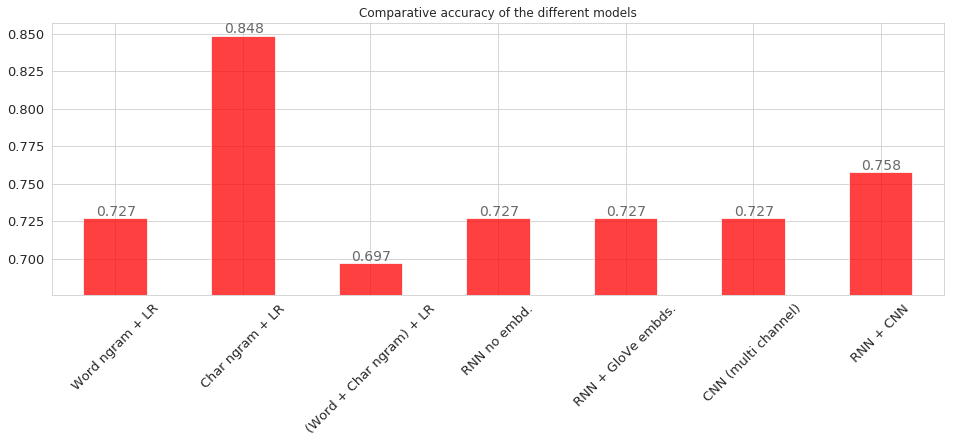

In [ ]:
%%time
import seaborn as sns
from sklearn.metrics import roc_auc_score
sns.set_style("whitegrid")
sns.set_palette("pastel")

predictions_files = os.listdir('./predictions/')

predictions_dfs = []
for f in predictions_files:
    aux = pd.read_csv('./predictions/{0}'.format(f))
    aux.columns = [f.strip('.csv')]
    predictions_dfs.append(aux)

predictions = pd.concat(predictions_dfs, axis=1)

scores = {}
scores2 = {}

for column in tqdm_notebook(predictions.columns, leave=False):
    if column != 'y_true':
        s = accuracy_score(predictions['y_true'].values, predictions[column].values)
        t = roc_auc_score(predictions['y_true'].values, predictions[column].values)
        scores[column] = s
        scores2[column] = t

scores = pd.DataFrame([scores], index=['accuracy'])
scores2 = pd.DataFrame([scores2], index=['auc'])

mapping_name = dict(zip(list(scores.columns), 
                        ['Char ngram + LR', '(Word + Char ngram) + LR', 
                           'Word ngram + LR', 'CNN (multi channel)',
                           'RNN + CNN', 'RNN no embd.', 'RNN + GloVe embds.']))

scores = scores.rename(columns=mapping_name)
scores = scores[['Word ngram + LR', 'Char ngram + LR', '(Word + Char ngram) + LR',
                'RNN no embd.', 'RNN + GloVe embds.', 'CNN (multi channel)',
                'RNN + CNN']]

scores = scores.T

ax = scores['accuracy'].plot(kind='bar', 
                             figsize=(16, 5), 
                             ylim=(scores.accuracy.min()*0.97, scores.accuracy.max() * 1.01), 
                             color='red', 
                             alpha=0.75, 
                             rot=45, 
                             fontsize=13)
ax.set_title('Comparative accuracy of the different models')

for i in ax.patches:
    ax.annotate(str(round(i.get_height(), 3)), 
                (i.get_x() + 0.1, i.get_height() * 1.002), color='dimgrey', fontsize=14)

Another common metric to evaluate algorithms is AUC (Area Under the Curve)

CPU times: user 45.5 ms, sys: 1.89 ms, total: 47.3 ms
Wall time: 47.1 ms


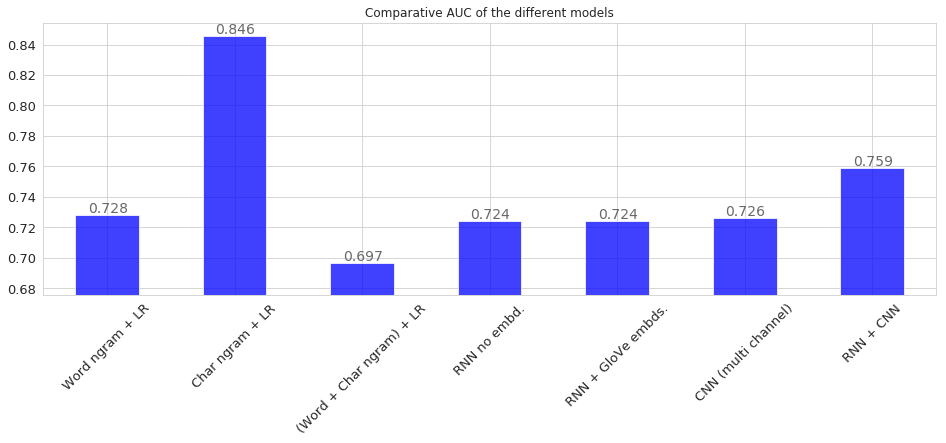

In [ ]:
%%time
scores2 = scores2.rename(columns=mapping_name)
scores2 = scores2[['Word ngram + LR', 'Char ngram + LR', '(Word + Char ngram) + LR',
                'RNN no embd.', 'RNN + GloVe embds.', 'CNN (multi channel)',
                'RNN + CNN']]

scores2 = scores2.T

ax = scores2['auc'].plot(kind='bar', 
                             figsize=(16, 5), 
                             ylim=(scores2.auc.min()*0.97, scores2.auc.max() * 1.01), 
                             color='blue', 
                             alpha=0.75, 
                             rot=45, 
                             fontsize=13)
ax.set_title('Comparative AUC of the different models')

for i in ax.patches:
    ax.annotate(str(round(i.get_height(), 3)), 
                (i.get_x() + 0.1, i.get_height() * 1.002), color='dimgrey', fontsize=14)

Let's quickly check the correlations between the predictions of the models.

CPU times: user 130 ms, sys: 131 ms, total: 261 ms
Wall time: 146 ms


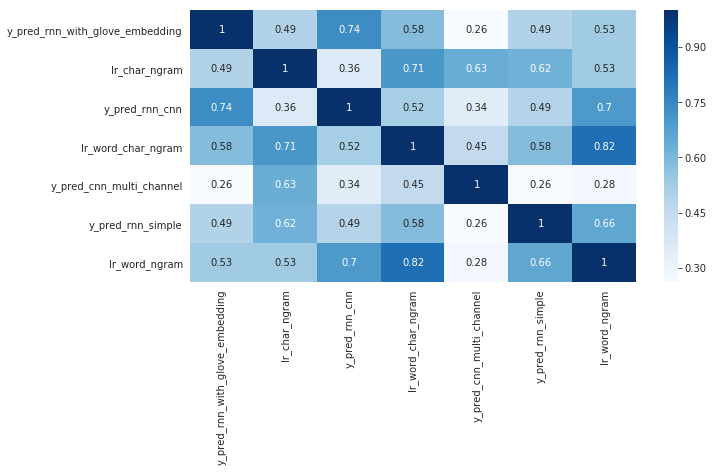

In [ ]:
%%time
fig = plt.figure(figsize=(10, 5))
sns.heatmap(predictions.drop('y_true', axis=1).corr(method='kendall'), cmap="Blues", annot=True);

# Playground

In [ ]:
text = 'The driver never showed up and I was charge twice'
text = " ".join(tokenize(text))
print(text)
for model in models:
  print(model)
  text_processed = models[model]['process']([text])
  #print(text_processed)
  print(models[model]['model'].predict(text_processed))

the driver never showed up and i was charge twice
lr_word
[1]
lr_char
[1]
lr_word_char
[1]
best_rnn_simple_model
[[0.36727735]]
best_rnn_model_with_glove_embeddings
[[0.8066559]]
best_cnn_model
[[0.40519887]]
best_rnn_cnn_model
[[0.9362855]]


# Conclusion

Here are rapid findings I think are worth sharing:

- Bag of word models using character ngrams can be very efficient. **Do not underestimate them!**. They are relatively cheap to compute, and also easy to interpret.

- RNNs are powerful. However, you can sometimes pump them with external pre-trained embeddings like GloVe. You can also use other popular embeddings such as word2vec and FastText.

- CNNs can be applied to text. They have the main advantage of being very fast to train. Besides, their ability to extract local features out of text is particularly interesting to nlp tasks.

- RNNs and CNNs can be stacked together to take advantags of both architectures.

This post was quite long, I hope you've enjoyed it. Don't hesitate to comment if you have any question or recommendation.

# Some helpful links to explore

Here are great resources I used when writing this post:

- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- http://wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

# Acknowledgments

This work is based in the [Ahmed Besbes](https://ahmedbesbes.com) work.